In [12]:
from itertools import product
from pathlib import Path

import skimage
import torch
from PIL import Image, ImageFilter
from torchvision import transforms as T


def tile(file: Path, target_dir: Path | None, tile_size: int, stride: int):
    img = Image.open(file)
    width, height = img.size

    grid = product(range(0, height - height % tile_size, stride), range(0, width - width % tile_size, stride))
    # print(list(grid))
    for i, j in grid:
        box = (j, i, j + tile_size, i + tile_size)
        cropped = img.crop(box)
        if target_dir is not None:
            out = target_dir / file.with_stem(f"{file.stem}_{i}_{j}").name
            cropped.save(out)


file = Path("/mnt/Files/code/super-resolution-pytorch/data/T91/raw/t1.png")
file_2 = Path("/mnt/Files/code/super-resolution-pytorch/data/T91/cropped/t1/t1_0_0.png")

In [2]:
import preload
from src.model import srcnn
from torch import optim

In [31]:
def srcnn_img_preprocess(img: Image.Image, scale: int = 2):
    new_height = (img.height // scale) * scale
    new_width = (img.width // scale) * scale
    img = img.resize((new_width, new_height), Image.Resampling.BICUBIC)

    lr_img = img.filter(ImageFilter.GaussianBlur(radius=2))
    lr_img = lr_img.resize((lr_img.width // scale, lr_img.height // scale), Image.Resampling.BICUBIC)
    lr_img = lr_img.resize((lr_img.width * scale, lr_img.height * scale), Image.Resampling.BICUBIC)

    return img, lr_img

In [32]:
a = Image.open(file)
b = T.ToTensor()(a)

b2 = T.ToTensor()(Image.open(file_2))

a_low = a.resize((a.size[0] // 2, a.size[1] // 2), Image.Resampling.BICUBIC)
b_low = T.ToTensor()(a_low)
b.shape, b_low.shape

(torch.Size([3, 176, 197]), torch.Size([3, 88, 98]))

In [33]:
a_hr, a_lr = srcnn_img_preprocess(a)

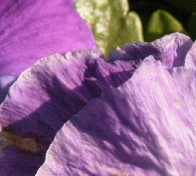

In [34]:
a_hr

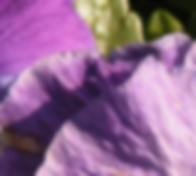

In [35]:
a_lr

In [36]:
a_hr.size, a_lr.size

((196, 176), (196, 176))

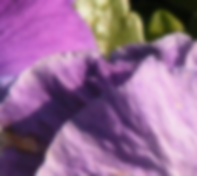

In [16]:
a.filter(ImageFilter.GaussianBlur(radius=2))

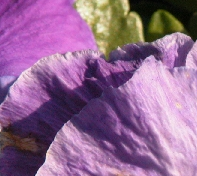

In [14]:
a

In [22]:
srcnn_model = srcnn.SRCNN()
b.shape, srcnn_model(b_low).shape

(torch.Size([3, 176, 197]), torch.Size([3, 88, 98]))

In [10]:
b2.shape, srcnn_model(b2).shape

(torch.Size([3, 33, 33]), torch.Size([3, 33, 33]))

In [11]:
from torch import nn

In [12]:
conv = nn.Conv2d(3, 3, kernel_size=33, stride=14)
conv(b).shape

torch.Size([3, 11, 12])

In [13]:
a.size, b.shape

((197, 176), torch.Size([3, 176, 197]))

In [ ]:
result = []
for file in Path("/mnt/Files/code/super-resolution-pytorch/data/T91/raw").glob("*"):
    if not file.is_file():
        continue

    a = Image.open(file)
    b = T.ToTensor()(a)
    c = conv(b)
    result.append(c.shape)

    target_dir = file.parent.parent / "T91" / "cropped" / file.stem
    target_dir.mkdir(exist_ok=True, parents=True)
    tile(file, target_dir, tile_size=33, stride=14)

In [36]:
sum([a[1] * a[2] for a in result])

22092

In [37]:
len(result)

91